# Getting Started with RAiDER

**Author**: Jeremy Maurer, David Bekaert, Simran Sangha, Yang Lei, Brett Buzzanga - Jet Propulsion Laboratory, California Institute of Technology

This notebook provides an overview of how to get started using the RAiDER package for estimating tropospheric RADAR delays, and other functionality included in the **raiderDelay.py** program. We give an example of how to download and process delays using the ERA-5 weather model for the Los Angeles region. 

In this notebook, we will demonstrate how to:
- Use the raiderDelay.py command-line utility to download and process tropospheric delays
- Generate Zenith Delays over the Los Angeles region
- Generate Zenith Delays for a set of GNSS stations over the Los Angeles region

The notebook will take approximately 15 minutes to run all the way through aside from the data download step. 

<div class="alert alert-warning">
The initial setup (<b>Prep A</b> section) should be run at the start of the notebook. The overview sections do not need to be run in order. 
</div>

<div class="alert alert-danger">
<b>Potential Errors:</b> 
    
- Pandas 1.2.0 or greater is required for some of the the plotting examples.   
- RAiDER needs to be installed to run this notebook  
- This notebook needs to be launched from the RAiDER environment
   
</div>


<div class="alert alert-info">
    <b>Terminology:</b>
    
- *Acquisition*: A single image acquired by a satellite at a particular time
- *AOI*: Area of interest: the lat/lon area (in RAiDER a square region) containing your query points
- *Interferogram*: An unwrapped image containing the surface displacement accumulated between two acquisitions.
- *SLC*: Single-look complex image. A complex single-band raster that contains a single focused RADAR frame from a SAR satellite. For Sentinel-1, SLCs are Level-1 products. 
- *Weather model*: A reanalysis weather product defining temperature, pressure, and humidity on a regular grid in some coordinate system (e.g., at regular lat/lon intervals in the standard EPSG:4326 reference frame).
- *Delay*: The apparent displacement in an interferogram that occurs solely due to changes in weather conditions between two acquisitions.
    </div>
    

## Table of Contents

[**Overview of the raiderDelay.py program**](#overview)  
[1. Details of the user input options](#user-input)  
  
[**Example Calculations**](#examples)  
[1. Downloading the weather model data using a bounding box](#bounding_box_example)  
[2. Compute Zenith Delays using a bounding box](#bounding_box_ztd)  
[3. Compute Zenith Delays using a list of GNSS stations](#station_list_example)  
[4. Visualizing Zenith Delays for a list of GNSS stations](#station_list_visualization)  
[5. Compute Slant Delays using ISCE raster files](#raster_example)  

## Prep A: Initial setup of the notebook

Please run the cell below prior to running the rest of the notebook to ensure RAiDER is installed and set your working directory. You can change the relevant directories as desired for your system.  

In [236]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
import xarray as xr
from wand.image import Image as WImage

## Defining the home and data directories
tutorial_home_dir = os.path.abspath(os.getcwd())
work_dir = os.path.abspath(os.getcwd())
print("Tutorial directory: ", tutorial_home_dir)
print("Work directory: ", work_dir)

# Verifying if RAiDER is installed correctly
try:
    import RAiDER
except:
    raise Exception('RAiDER is missing from your PYTHONPATH')

os.chdir(work_dir)

Tutorial directory:  /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/RAiDER_tutorial
Work directory:  /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/RAiDER_tutorial


## Overview of the raiderDelay.py program
<a id='overview'></a>

**`raiderDelay.py`** is a command-line program written in Python that allows for easy downloading and processing of tropospheric weather delays for InSAR correction or comparison with GNSS tropospheric delays.
raiderDelay.yaml shows all the different options that can be passed to RAiDER; the software is extensible such that arguments can also be passed for custom workflows if desired. 

In [2]:
# Running raiderDelay.py -h will print the help menu
!raiderDelay.py -h

usage: raiderDelay.py [-h] [-g] [--start STEP] [--end STEP] [--dostep STEP]
                      [customTemplateFile]

Command line options for RAiDER processing to calculate tropospheric
delay from a weather model. Default options can be found by running
raiderDelay.py --generate_config.

positional arguments:
  customTemplateFile    custom template with option settings. ignored if the
                        default smallbaselineApp.cfg is input.

options:
  -h, --help            show this help message and exit
  -g, --generate_template
                        generate default template (if it does not exist) and
                        exit.

steps processing (start/end/dostep):
  Command line options for steps processing with names are chosen from the following list:
  ['load_weather_model', 'calculate_delays']
  In order to use either --start or --dostep, it is necessary that a
  previous run was done using one of the steps options to process at least
  through the step immediatel

The **load_weather_model** step downloads and stores locally the weather model output according to the user specifications in the yaml file. Note that the files will be not be downloaded again if they already exist.

The **calculate_delays** step performs the computation as specified by the [los_group](#los_group).

## Details of the user input options
<a id='user-input'></a>
RAiDER is quite flexible in terms of the input arguments it allows.  
Options are specified in a configuration file. Run the following to see an example file.

[//]: # "![example_yaml.png](attachment:350ef453-f997-4a53-b91a-8e7da11fb72b.png)"

In [63]:
%pycat raider_example_LA_bbox.yaml

### 1. weather_model
<a id='weather_model_arg'></a>

This parameter is required. 

RAiDER supports many weather models (though not all are fully tested at this time), including: 
- [ERA-5](#https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5),
- ERA-5T,
- [ERA-I](#https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era-interim),
- [MERRA-2](#https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/),
- [HRRR](#https://rapidrefresh.noaa.gov/hrrr/),
- [GMAO](#https://gmao.gsfc.nasa.gov/),
- [HRES](#https://www.ecmwf.int/en/forecasts/datasets/set-i), and
- [NCMR](#https://www.ncmrwf.gov.in/)

Custom weather models can also be defined using the [template file](https://github.com/dbekaert/RAiDER/blob/8265cfb05678b156f10ad9866f5753fbd91b6f7f/tools/RAiDER/models/template.py) to define a custom reader and adding the model to the [ALLOWED_MODELS](https://github.com/dbekaert/RAiDER/blob/8265cfb05678b156f10ad9866f5753fbd91b6f7f/tools/RAiDER/models/allowed.py) list. 
Setting up the licensing and API keys for each weather model is different; see [WeatherModels.md](https://github.com/dbekaert/RAiDER/blob/8265cfb05678b156f10ad9866f5753fbd91b6f7f/WeatherModels.md) in the main RAiDER repository for more details. 

### 2. date_group
<a id='date_arg'></a>

This argument group is required. 

Dates are specified as either a single date, a date range, or a date list.  
`date_start`: a single date, specified in psuedo-ISO 8601 format: 20180101, 2018-01-01, etc.   
`date_end`: a single date, specified in psuedo-ISO 8601 format, last date in range minus one `date_step` to process.  
`date_step`: integer, interval in days between date_start and date_end to process.  
`date_list`: Python list of dates to process in psuedo-ISO 8601 format.  

### 3. time_group
<a id='time_arg'></a>

This argument is required. 

`time`: UTC time to process in psuedo-ISO 8601 format. Accepted formats include:
1) T020000  
2) T02:00:00.000  
3) T0200  
4) 12:00:00  
5) 120000  
etc. 

`time_end`: Last UTC time to consider when processing an orbit file. This option is only needed if an orbit file is specified in the `los_group`

### 4. aoi_group
<a id='aoi_arg'></a>

This group is required if not pulling lat/lon info from a geocoded file (see `los_group` options).

RAiDER can handle several different types of AOIs: 
1) `bounding_box`: a bounding box in SNWE format, in which case the weather model grid nodes are used for x/y or lat/lon locations.  
2) `lat_file, lon_file`: Latitude and longitude grid files in gridded radar coordinates; e.g., files generated using ISCE
3) `station_file`: a comma-delimited file containing at minimum the columns "Lat" and "Lon," and optionally "Hgt_m."  
4) `utm_zone, grid_x, grid_y`: A UTM grid with specified x- and y-spacing in meters.  
5) A geocoded DEM or line-of-sight files, from which the lat/lon information can be used (see DEM/LOS options below).  

### 5. height_group
<a id='height_arg'></a>

This group is optional. 

Ellipsoidal heights are needed to compute absolute delays.
If using a bounding box or UTM cube, the heights of the weather model grid will be used by default; optionally a list of height_levels may be passed. 
For lat/lon rasters or a station file, a DEM can either be provided by the user or downloaded on the fly. Options include: 
1) `dem`: user-provided DEM file to use
2) `use_dem_latlon`: This option should be specified as True if the user wishes to compute delays on the DEM grid. **NOTE**: This option is only available for ZTD calculation. 
3) `height_file_rdr`: A gridded height file in radar coordinates, such as produced by ISCE. This is to be used with corresponding lat/lon gridded files (see the information on [AOI group](#aoi_arg) above). 
4) `height_levels`: A Python list of height levels. Can be used with the bounding box / UTM grid AOI options and will return delays at the specified heights. 
5) If no DEM is specified and a bounding box / UTM cube is not used, RAiDER will automatically download the [Copernicus GLO-30 DEM](https://spacedata.copernicus.eu/explore-more/news-archive/-/asset_publisher/Ye8egYeRPLEs/blog/id/434960) on the fly and interpolate to the specified query points in the AOI group. 

**NOTE**: No DEM is needed for the `bounding_box` option. If nothing is specified under this group, delays will be calculated at the weather model grid nodes. 
If `height_levels` is specified, delays will be calculated at the weather model grid lat/lon coordinates and the specified heights. 
If either of these options or a UTM grid is provided, delays are returned as a 3D cube in netcdf file format. 

### 6. los_group
<a id='los_arg'></a>

This group is optional and used to specify line-of-sight information. 

Three options are available in RAiDER. Calculation of: 
1) Zenith total delays (ZTD) (**Default**)
2) Slant total delays (STD) by projection of ZTD using the incidence angle: STD = ZTD / cos(inc)
3) STD by  numerically integrating the delays along along raypaths extending from the ground pixels to the top of the atmosphere. The rays follow the look vector at the ground pixel (i.e. no bending). 

STD parameters:  
- `ray_trace`: whether or not to use ray-tracing if line-of-sight files are provided; i.e. option 3 above as opposed to projection, option 2 above.  
- `zref`: if `ray_trace` is True, then this is the maximum integration height to use in meters.  

STD input options:  
- `los_file`: a gridded raster file containing look vector information. Format is specified by `los_convention`.  
- `los_convention`: File format of the `los_file`. Options are `isce` or `hyp3`.  
- `los_cube`: a NETCDF file containing georeferenced look vectors defined on a 3D grid.  
- `orbit_file`: A compatible orbit file to use in determining look vectors.  

ISCE format line-of-sight files are two-band files with incidence angle in band 1 and heading in degrees clockwise from north in band 2. 

**HYP3 format is ??**

### 7. runtime_group
<a id='runtime_arg'></a>

RAiDER allows user flexibility by specifying a variety of runtime parameters, including directories to write to, file formats, and projections. 

#### raster_format
- GDAL-compatible raster image format
- Default is GTiff
- Only used when outputs are rasters

#### output_directory
- The location of the output files. **(Default: current directory)**

#### weather_model_directory
- Specifies the directory of weather model files **(Default: \<output_location\>/weather_files)**

#### cube_spacing_in_m
- spacing for cube over which rays are calculated

#### output_projection
- CRS (geographic projection) of the output delays. **Default: WGS-84**

To see many of the options that RAiDER supports, you can generate the default config file:

In [14]:
!raiderDelay.py -g

And view it:

In [64]:
%pycat raiderDelay.yaml

## Examples using RAiDER
<a id='runtime_arg'></a>

In this section we will demostrate some of the basic capabilities of RAiDER, using a region in southern California shown below. 
The study area is around Los Angles, chosen to be a a square box 10 x 10 deg centered on 34 deg latitude, -118 deg  longitude. (See the optical image below.)

![Optical Image of Los Angeles and surrounding area]()
<img src="img/optical.png" width="300" height="150">

### Downloading the weather model data using a bounding box
<a id='bounding_box_example'></a>

RAiDER uses weather model data from third parties to calculate weather model delays. For this excercise we will use the weather model available from the __[Global Model Assimilation Office](https://gmao.gsfc.nasa.gov/weather_prediction/)__ at NASA. 

You can also try the ERA-5 model from the __[European Medium-range Weather Forecast](https://www.ecmwf.int/)__ if you have access to ECMWF weather models, simply change "GMAO" to "ERA5".

In [22]:
# take a look at the configuration file
%pycat raider_example_LA_bbox.yaml

In [65]:
# download the weather model output
!raiderDelay.py raider_example_LA_bbox.yaml --dostep load_weather_model

Run routine processing with raiderDelay.py on steps: ['load_weather_model']
Remaining steps: ['calculate_delays']
--------------------------------------------------
/Users/buzzanga/Miniconda3/envs/RAiDER/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Extent of the weather model is (xmin, ymin, xmax, ymax):-123.28, 28.88, -112.97, 39.12
Extent of the input is (xmin, ymin, xmax, ymax): -123.00, 29.00, -113.00, 39.00


The weather model data is accessed through different APIs depending on the model. GMAO and MERRA-2 are both directly accessed using the OpenDAP interface, while ECMWF models have a custom API. RAiDER automatically uses the appropriate API for the weather model that you specify. Each model has a custom reader defined that is used to access the API and manipulate it to a consistent set of variables.

By default the weather model files are stored in a subfolder of the local directory called "weather_files." You can change this using the `--weatherFiles` option described above. 

In [27]:
# We can look at the downloaded file
!ls weather_files/

GMAO_2020_01_03_T00_00_00.nc
GMAO_2020_01_03_T00_00_00_29N_39N_123W_113W.nc


The downloaded weather model is a NETCDF file, so it can be viewed and manipulated using GDAL or any NETCDF utility or package. 

In [32]:
# GDAL provides an API to access the variables and attributes of the file
!gdalinfo weather_files/GMAO_2020_01_03_T00_00_00.nc

Driver: netCDF/Network Common Data Format
Files: weather_files/GMAO_2020_01_03_T00_00_00.nc
Size is 512, 512
Metadata:
  NC_GLOBAL#Conventions=CF-1.6
  NC_GLOBAL#datetime=2020_01_03T00_00_00
  NC_GLOBAL#date_created=2022_11_17T09_41_52
  NC_GLOBAL#title=GMAO weather model data
Subdatasets:
  SUBDATASET_1_NAME=NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00.nc":H
  SUBDATASET_1_DESC=[72x41x33] mid_layer_heights (32-bit floating-point)
  SUBDATASET_2_NAME=NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00.nc":QV
  SUBDATASET_2_DESC=[72x41x33] specific_humidity (32-bit floating-point)
  SUBDATASET_3_NAME=NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00.nc":PL
  SUBDATASET_3_DESC=[72x41x33] mid_level_pressure (32-bit floating-point)
  SUBDATASET_4_NAME=NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00.nc":T
  SUBDATASET_4_DESC=[72x41x33] air_temperature (32-bit floating-point)
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0,  512.0)
Upper Right (  512.0,    0.0)
Lower Righ

Notice the file contains (usually) four variables: height, pressure, temperature, and humidity. In some cases, pressure is not explicitly stored; instead the variables are provided at fixed pressure levels, or an intermediate variable like geopotential is provided. 

Notice that no information is printed about the projection or size of the variables. These variables can be queried using GDAL individually to show the projection and shape information. 

In [35]:
!cd weather_files
!gdalinfo NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00.nc":QV
!cd ..

Driver: netCDF/Network Common Data Format
Files: weather_files/GMAO_2020_01_03_T00_00_00.nc
Size is 33, 41
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEU

Once the weather model file has been downloaded, you can compute delays for the same area without re-downloading. RAiDER will check your input query points (such as a bounding box) against the extents of the downloaded file and proceed with processing if the weather model file includes a large enough area. If not, then it will ask you to delete the existing file so that it can download a new one. 

In [124]:
# If we try to run the same datetime but a larger bounding box, we get a message asking us to delete the existing file
!raiderDelay.py ./example_yamls/raider_example_LA_bbox-1.yaml --dostep load_weather_model

Run routine processing with raiderDelay.py on steps: ['load_weather_model']
Remaining steps: ['calculate_delays']
--------------------------------------------------
Starting to run the weather model calculation
Time type: <class 'datetime.datetime'>
Time: 20200103
Max integration height is 15000.0 m
Beginning weather model pre-processing
Download-only is False
/Users/buzzanga/Miniconda3/envs/RAiDER/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Using netcdf:/Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/RAiDER_tutorial/weather_files/GMAO_2020_01_03_T00_00_00.nc:T for bounds estimation
Extent of the weather model is (xmin, ymin, xmax, ymax):-123.28, 28.88, -112.97, 39.12
Extent of the input is (xmin, ymin, xmax, ymax): -123.00, 25.00, -113.00, 45.00
ERROR: The weather model passed does not c

### Compute Zenith Delays for a bounding box
<a id='bounding_box_ztd'></a>

If you only specify a bounding box as your AOI, RAiDER will compute the Zenith delay at the locations of the native grid nodes of the weather model itself. Because our bounding box is the same as before, RAiDER will skip the download step and directly process the delays. 

RAiDER will warn you that it is using the existing weather model file, which is specific to a 1) date, 2) time, 3) model, and 4) AOI. 

In [67]:
!ls weather_files/

GMAO_2020_01_03_T00_00_00.nc
GMAO_2020_01_03_T00_00_00_29N_39N_123W_113W.nc


Since we've already downloaded the file and we're using the native grid nodes as our query points, the processing happens fairly quickly. 

<div class="alert alert-danger">
<b>Note:</b> 
Different weather models have different resolutions. GMAO has about a 50 km horizontal grid node spacing, while HRRR for example has a 3-km horizontal grid node spacing. As a result, some weather models will be much faster to process than others. </div>



In [238]:
# passing the original bounding 
!raiderDelay.py ./example_yamls/raider_example_LA_bbox.yaml

Run routine processing with raiderDelay.py on steps: ['load_weather_model', 'calculate_delays']
Remaining steps: ['calculate_delays']
--------------------------------------------------
/Users/buzzanga/Miniconda3/envs/RAiDER/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Extent of the weather model is (xmin, ymin, xmax, ymax):-124.22, 27.88, -112.03, 40.12
Extent of the input is (xmin, ymin, xmax, ymax): -123.00, 29.00, -113.00, 39.00
Finished writing data to: /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/RAiDER_tutorial/GMAO_tropo_20200103T000000_ztd.nc


Once the delays have been processed, there are several files that get created. One is a set of plots that are for sanity checking the weather model data. These are .pdf files and show the weather model variables at two different heights. The weather file also shows profile at a central point. These plots are  used to ensure that custom weather models are getting processed correctly (see __[Defining Custom Weather Models](../Defining_Custom_Weather_Models/Defining_custom_Weather_Models_in_RAiDER.ipynb)__ for more details).

In [70]:
!ls *.pdf

GMAO_refractivity_hgt500_and_15000m.pdf GMAO_weather_hgt500_and_15000m.pdf


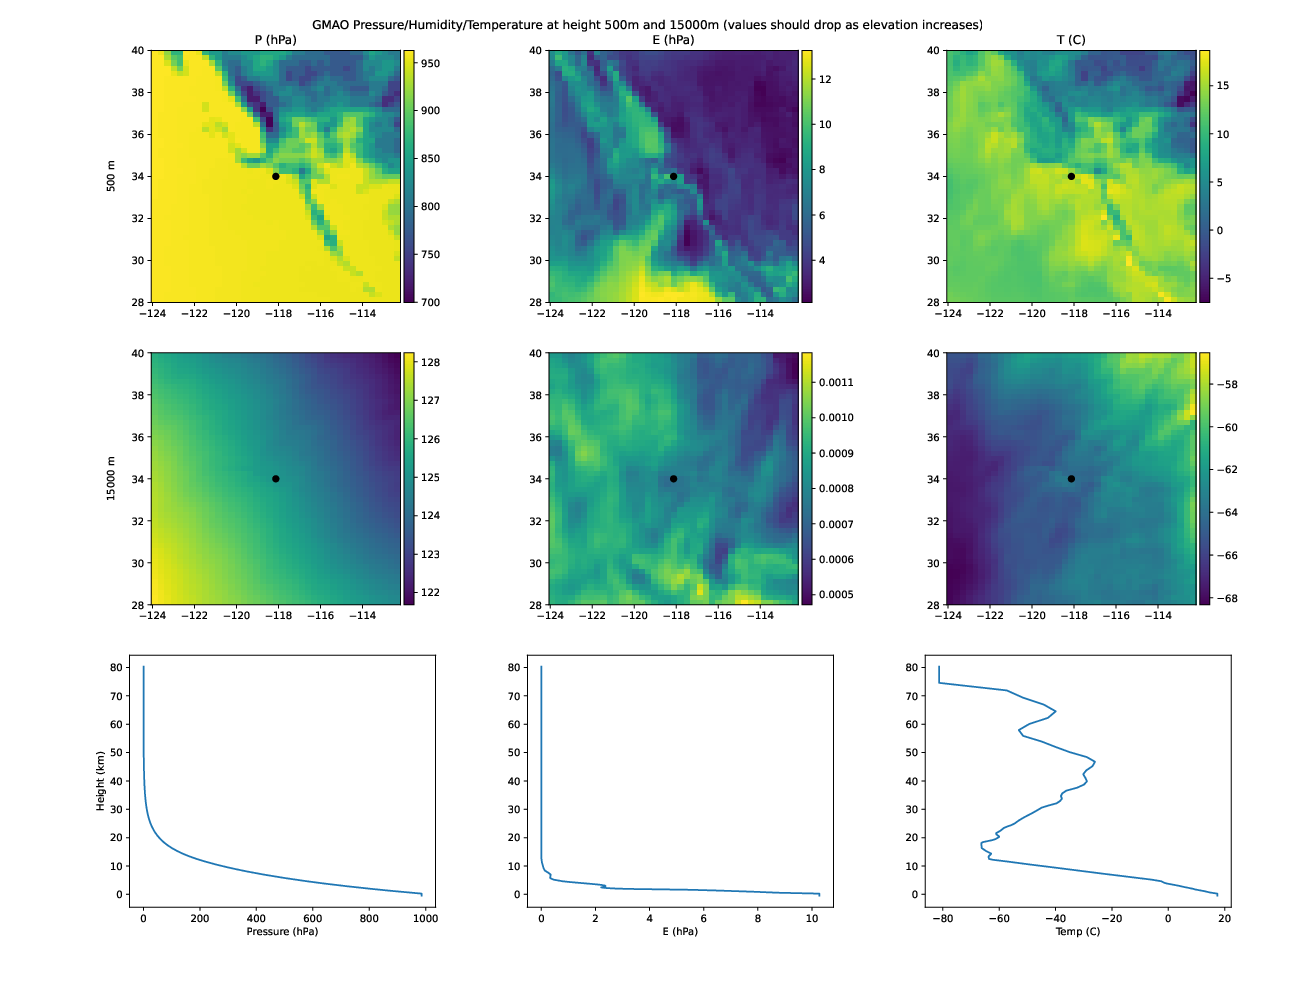

In [229]:
WImage(filename='GMAO_weather_hgt500_and_15000m.pdf')

In addition, there are log files that get printed out. These can be especially helpful when troubleshooting or debugging. The "debug.log" file records all of the same information that gets printed to the console, while the "error.log" file records warnings and error messages, including tracebacks. These files are appended to instead of being overwritten, so the output of several calls to raiderDelay.py will be saved. 

In [72]:
!ls *.log

debug.log error.log


In [73]:
!tail debug.log

    (_, _) = tropo_delay(t, w, f, params)
  File "/Volumes/GoogleDrive-112189022494608150062/My Drive/RAiDER_git/tools/RAiDER/delay.py", line 89, in tropo_delay
    weather_model_file = prepareWeatherModel(
  File "/Volumes/GoogleDrive-112189022494608150062/My Drive/RAiDER_git/tools/RAiDER/processWM.py", line 64, in prepareWeatherModel
    raise RuntimeError(
RuntimeError: The weather model passed does not cover all of the input points; please delete or rename it so another can be downloaded.
[2022-11-17 10:35:58,674]  prepareWeatherModel:43    WARNING    Weather model already exists, please remove it ("['/Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/RAiDER_tutorial/weather_files/GMAO_2020_01_03_T00_00_00.nc']") if you want to download a new one.
[2022-11-17 10:35:58,698]     checkContainment:454   INFO       Extent of the weather model is (xmin, ymin, xmax, ymax):-123.28, 28.88, -112.97, 39.12
[2022-11-17 10:35:58,698]     checkContainment:456   INFO       Extent of the inp

In [74]:
!tail error.log

Traceback (most recent call last):
  File "/Volumes/GoogleDrive-112189022494608150062/My Drive/RAiDER_git/tools/RAiDER/runProgram.py", line 33, in main
    (_, _) = tropo_delay(t, w, f, params)
  File "/Volumes/GoogleDrive-112189022494608150062/My Drive/RAiDER_git/tools/RAiDER/delay.py", line 89, in tropo_delay
    weather_model_file = prepareWeatherModel(
  File "/Volumes/GoogleDrive-112189022494608150062/My Drive/RAiDER_git/tools/RAiDER/processWM.py", line 64, in prepareWeatherModel
    raise RuntimeError(
RuntimeError: The weather model passed does not cover all of the input points; please delete or rename it so another can be downloaded.
[2022-11-17 10:35:58,674]  prepareWeatherModel:43    WARNING    Weather model already exists, please remove it ("['/Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/RAiDER_tutorial/weather_files/GMAO_2020_01_03_T00_00_00.nc']") if you want to download a new one.
[2022-11-17 10:35:58,699]  prepareWeatherModel:83    WARNING    The processed we

Notice that there are flags ("INFO", "WARNING", etc.) that alert you to the type of message that is being saved. 

Finally, we have the processed delay files. These are of two types: 
1) A NETCDF file containing a modified version of the weather model that has been processed and regularized   
2) Depending on the type of input query points, there may be a separate final delay file  

In [59]:
!ls -lt weather_files/

total 8424
-rw-r--r--  1 buzzanga  staff  3796162 Nov 17 09:41 GMAO_2020_01_03_T00_00_00_29N_39N_123W_113W.nc
-rw-r--r--  1 buzzanga  staff   513322 Nov 17 09:41 GMAO_2020_01_03_T00_00_00.nc


In the case of a bounding box input, there is no additional file written; the delays are stored in the processed weather model file. 

As before, we can use GDAL to examine the processed NETCDF file.

In [62]:
!gdalinfo weather_files/GMAO_2020_01_03_T00_00_00_29N_39N_123W_113W.nc

Driver: netCDF/Network Common Data Format
Files: weather_files/GMAO_2020_01_03_T00_00_00_29N_39N_123W_113W.nc
Size is 512, 512
Metadata:
  NC_GLOBAL#Conventions=CF-1.6
  NC_GLOBAL#datetime=2020_01_03T00_00_00
  NC_GLOBAL#date_created=2022_11_17T09_41_55
  NC_GLOBAL#title=Weather model data and delay calculations
Subdatasets:
  SUBDATASET_1_NAME=NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00_29N_39N_123W_113W.nc":latitude
  SUBDATASET_1_DESC=[145x41x33] latitude (64-bit floating-point)
  SUBDATASET_2_NAME=NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00_29N_39N_123W_113W.nc":longitude
  SUBDATASET_2_DESC=[145x41x33] longitude (64-bit floating-point)
  SUBDATASET_3_NAME=NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00_29N_39N_123W_113W.nc":t
  SUBDATASET_3_DESC=[145x41x33] temperature (32-bit floating-point)
  SUBDATASET_4_NAME=NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00_29N_39N_123W_113W.nc":p
  SUBDATASET_4_DESC=[145x41x33] pressure (32-bit floating-point)
  SUBDATASET_5_NAME=NETCDF

Notice that there are several new variables in comparison with the original weather model data, including lats/lons and two new variables "wet" and "hydro;" these are the wet and hydrostatic refractivities (point-wise delays) that are calculated using the equation:

$$ N_{\text{hydro}} = k_1 \frac{P}{T} $$

$$ N_{\text{wet}} = k_2 \frac{e}{T} + k_3 \frac{e}{T^2} $$

These are integrated in the z-direction to produce the "wet_total" and "hydro_total" variables, which are the integrated (i.e. total) delays:

$$ \text{ZTD}_{\text{wet}} = 10^{-6} \int_{z = h}^{z_{ref}} N_{\text{wet}}(z) \hspace{3pt} dz $$

$$ \text{ZTD}_{\text{hydro}} = 10^{-6} \int_{z = h}^{z_{ref}} N_{\text{hydro}}(z) \hspace{3pt} dz $$

When passing a station list or raster files containing query points, RAiDER will generate separate files containing the wet and hydrostatic total delays in the main directory. 

Although not explicit in variable descriptions above, a further difference between the original and processed weather model data is that it is all in a uniform cube; i.e. the grid heights are the same across the entire area of interest. In contrast, the native weather models typically use some other fixed variable such as pressure levels. 

### Compute Zenith delays using a GNSS station list
<a id='station_list_example'></a>

When using a GNSS station list, the program by default will create a bounding box around the list of points. 
For demonstration purposes, we will use an example list of stations from
the L.A. area so that we don't have to download another weather model file. 

The station file **must be comma-delimited, and must contain at the minimum column names "Lat" and "Lon."** By default, RAiDER will download a DEM to get the height information for the list of stations; if the heights are specified in a column named "Hgt_m" RAiDER will use those and save some processing time. 

In [176]:
!raiderDelay.py ./example_yamls/raider_example_LA_GNSS.yaml

Run routine processing with raiderDelay.py on steps: ['load_weather_model', 'calculate_delays']
Remaining steps: ['calculate_delays']
--------------------------------------------------
/Users/buzzanga/Miniconda3/envs/RAiDER/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Extent of the weather model is (xmin, ymin, xmax, ymax):-124.22, 27.88, -112.03, 40.12
Extent of the input is (xmin, ymin, xmax, ymax): -122.96, 29.03, -113.01, 39.00
Finished writing data to /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/RAiDER_tutorial/GMAO_wet_20200103T000000_ztd.csv


We can compare the files in weather_files to see what has been added: 

In [134]:
!ls -lt weather_files/

total 15840
-rw-r--r--  1 buzzanga  staff  3796162 Nov 17 10:52 GMAO_2020_01_03_T00_00_00_30N_39N_123W_114W.nc
-rw-r--r--@ 1 buzzanga  staff  3796162 Nov 17 09:41 GMAO_2020_01_03_T00_00_00_29N_39N_123W_113W.nc
-rw-r--r--  1 buzzanga  staff   513322 Nov 17 09:41 GMAO_2020_01_03_T00_00_00.nc


We now have a new file in the base directory, which has been copied from the original station list file and to which has been added some new variables.

In [135]:
!ls *.csv

GMAO_wet_20200103T000000_ztd.csv


In [138]:
pd.read_csv('GMAO_wet_20200103T000000_ztd.csv').head()

,ID,Lat,Lon,Hgt_m,wetDelay,hydroDelay,totalDelay
0,5PTS,36.429179,-120.264977,56.523155,0.068428,2.304436,2.372864
1,7OAK,37.594986,-114.759090,1713.278104,0.046192,1.885331,1.931523
2,7ODM,34.116407,-117.093192,762.071709,0.056272,2.109115,2.165387
3,ACSB,33.274265,-117.444891,-12.296036,0.080302,2.313523,2.393825
4,ACSX,33.274265,-117.444892,-12.291230,0.080302,2.313522,2.393823


You can see that the new .csv file contains the original station data, but with the addition of the wet, hydrostatic, and total delays, all in meters. 

### Visualizing Zenith delays for a list of GNSS stations
<a id='station_list_visualization'></a>

Once we have the delays in the .csv file, we can use Pandas to view and manipulate the data

In [156]:
delays0 = pd.read_csv('GMAO_wet_20200103T000000_ztd.csv')
delays  = delays0[delays0.totalDelay>0] # drop stations without ZTD values
delays.head()

,ID,Lat,Lon,Hgt_m,wetDelay,hydroDelay,totalDelay
0,5PTS,36.429179,-120.264977,56.523155,0.068428,2.304436,2.372864
1,7OAK,37.594986,-114.759090,1713.278104,0.046192,1.885331,1.931523
2,7ODM,34.116407,-117.093192,762.071709,0.056272,2.109115,2.165387
3,ACSB,33.274265,-117.444891,-12.296036,0.080302,2.313523,2.393825
4,ACSX,33.274265,-117.444892,-12.291230,0.080302,2.313522,2.393823


<AxesSubplot: xlabel='Height (m)', ylabel='Total Delay (m)'>

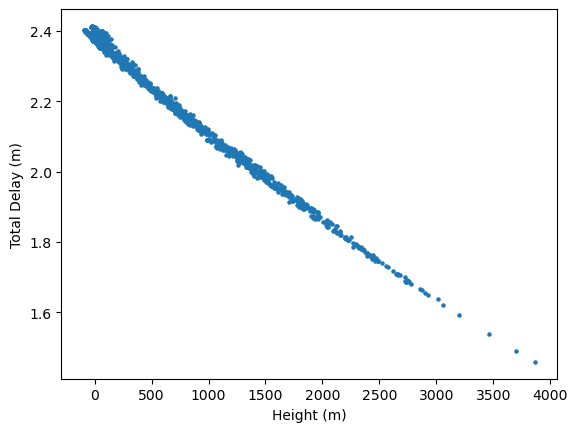

In [149]:
delays.plot.scatter(x='Hgt_m', y='totalDelay', marker='.', xlabel = 'Height (m)', ylabel='Total Delay (m)');

We can also plot the total (absolute) delays in space. 

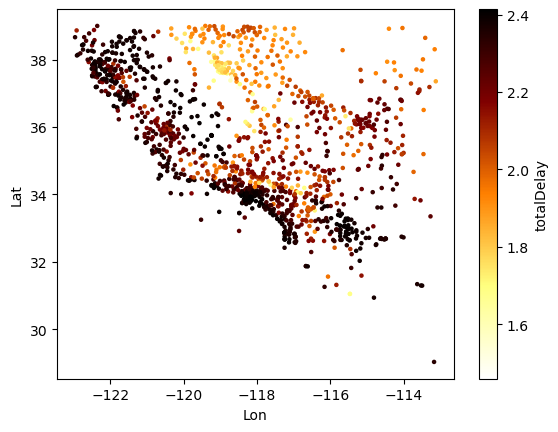

In [163]:
delays.plot.scatter(x='Lon',y='Lat', marker='.', c='totalDelay', cmap='afmhot_r'); # units are meters

### Compute Slant Delays with ISCE raster files
<a id='raster_example'></a>

In [177]:
!raiderDelay.py ./example_yamls/raider_example_UK-isce.yaml

Run routine processing with raiderDelay.py on steps: ['load_weather_model', 'calculate_delays']
Remaining steps: ['calculate_delays']
--------------------------------------------------
/Users/buzzanga/Miniconda3/envs/RAiDER/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Extent of the weather model is (xmin, ymin, xmax, ymax):-5.16, 51.88, 0.16, 57.12
Extent of the input is (xmin, ymin, xmax, ymax): -5.00, 52.00, 0.00, 57.00
Processing slice 1 / 5: 0.0
Processing slice 2 / 5: 50.0
Processing slice 3 / 5: 100.0
Processing slice 4 / 5: 500.0
Processing slice 5 / 5: 1000.0
Finished writing data to: /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/RAiDER_tutorial/GMAO_tropo_20211102T062159_std.nc


We can again compare the files in weather_files to see what has been added: 

In [179]:
!ls -lt weather_files

total 29392
-rw-r--r--  1 buzzanga  staff  5258901 Nov 17 16:22 GMAO_2020_01_03_T00_00_00_30N_39N_123W_114W.nc
-rw-r--r--  1 buzzanga  staff  1099113 Nov 17 15:36 GMAO_2021_11_02_T06_21_59_52N_57N_5W_0E.nc
-rw-r--r--  1 buzzanga  staff   173828 Nov 17 15:36 GMAO_2021_11_02_T06_21_59.nc
-rw-r--r--  1 buzzanga  staff  1105858 Nov 17 15:35 GMAO_2021_11_03_T06_21_59_52N_57N_5W_0E.nc
-rw-r--r--  1 buzzanga  staff   175006 Nov 17 15:35 GMAO_2021_11_03_T06_21_59.nc
-rw-r--r--  1 buzzanga  staff  1100374 Nov 17 15:28 GMAO_2021_11_03_T00_00_00_52N_57N_5W_0E.nc
-rw-r--r--  1 buzzanga  staff   174397 Nov 17 15:28 GMAO_2021_11_03_T00_00_00.nc
-rw-r--r--  1 buzzanga  staff  5258901 Nov 17 15:19 GMAO_2020_01_03_T00_00_00_28N_40N_124W_112W.nc
-rw-r--r--  1 buzzanga  staff   691187 Nov 17 15:19 GMAO_2020_01_03_T00_00_00.nc


And again have a new file in the base directory which contains coordinates and the delay components on the cube:

In [182]:
!h5ls GMAO_tropo_20211102T062159_std.nc

cube_projection          Dataset {SCALAR}
hydro                    Dataset {5, 152, 152}
wet                      Dataset {5, 152, 152}
x                        Dataset {152}
y                        Dataset {152}
z                        Dataset {5}


We can then look at the total delay by summing the wet and hydrostatic delay:

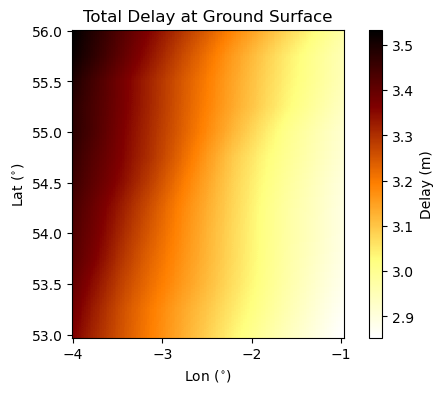

In [218]:
ds          = xr.open_dataset('GMAO_tropo_20211102T062159_std.nc')
ds['total'] = ds['hydro'].sel(z=0) + ds['wet'].sel(z=0)

fig, axes   = plt.subplots(figsize=(4,4))
im      = axes.pcolor(ds.x, ds.y, ds.total, cmap='afmhot_r')
divider = make_axes_locatable(axes)
dct_ps = dict(size='5%', pad=0.25)
cbar_ax = divider.append_axes('right', **dct_ps)

cbar = plt.colorbar(im, cax=cbar_ax, label='Delay (m)') 
axes.set_title('Total Delay at Ground Surface')
axes.set_xlabel('Lon ($^{\circ}$)')
axes.set_ylabel('Lat ($^{\circ}$)');

Note that the z (height) increases with altitude, and each z level contains the total delay at that point.